##  Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data
from sklearn.model_selection import StratifiedShuffleSplit
training_file = r'C:\Users\Administrator\Self driving\Term2\CarND-Traffic-Sign-Classifier-Project\traffic-signs-data\train.p'
testing_file = r'C:\Users\Administrator\Self driving\Term2\CarND-Traffic-Sign-Classifier-Project\traffic-signs-data\test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_all, y_train_all = train['features'], train['labels']
sss=StratifiedShuffleSplit(n_splits=10,test_size=0.2)
for train_index,valid_index in sss.split(X_train_all, y_train_all):
    X_train,y_train=X_train_all[train_index], y_train_all[train_index]
    X_valid,y_valid=X_train_all[valid_index], y_train_all[valid_index]
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 

### Provide a Basic Summary of the Data Set

In [2]:

import pandas as pd

n_train = X_train.shape[0]


n_validation = X_valid.shape[0]
print('Number of valid examples:',n_validation )

n_test = X_test.shape[0]


image_shape = X_train.shape[1:]


n_classes = len(pd.DataFrame(y_train)[0].unique())

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of valid examples: 7842
Number of training examples = 31367
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).

13
(32, 32, 3)


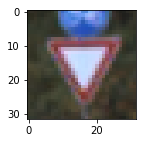

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
index = random.randint(0, len(X_train))
image = X_train[index]

plt.figure(figsize=(2,2))
plt.imshow(image, cmap="gray")
print(y_train[index])
print(image.shape)

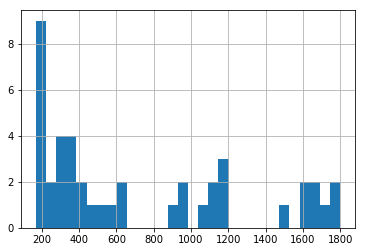

In [4]:
count_train=pd.DataFrame(y_train)[0].value_counts()
count_valid=pd.DataFrame(y_valid)[0].value_counts()
count_test=pd.DataFrame(y_test)[0].value_counts()
count_train.hist(bins=30)

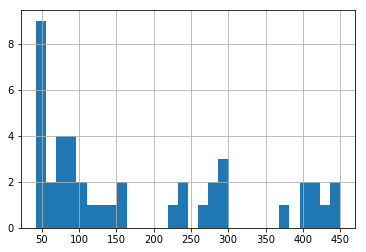

In [6]:
count_valid.hist(bins=30)

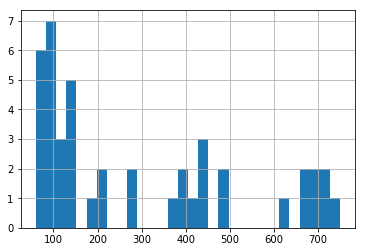

In [7]:
count_test.hist(bins=30)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. 

### Pre-process the Data Set (normalization, grayscale, etc.)

In [4]:

import cv2
import numpy as np
def gray(img):
    #transform single image to gray pics
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
def scale(input):
    #input:the gray tensor,scale the input to (-1,1) 
    return (input*1.0-128)/128


def preprocess_gray(input):
    #input:the origin features,like:X_train/X_valid
    X_new=[]
    for img in input:
        temp=gray(img)
        X_new.append(temp)
    X_new=np.array(X_new)
    print(type(X_new))
    print('Before scale:',X_new.shape,'the mini value:',X_new.min(),'the maxi value is:',X_new.max())
    X_new=X_new.reshape([input.shape[0],input.shape[1],input.shape[2],1])
    X_new=scale(X_new)
    print('After scale:',X_new.shape,'the mini value:',X_new.min(),'the maxi value is:',X_new.max())
    return X_new
X_train_gray=preprocess_gray(X_train)
X_valid_gray=preprocess_gray(X_valid)
X_test_gray=preprocess_gray(X_test)


<class 'numpy.ndarray'>
Before scale: (31367, 32, 32) the mini value: 3 the maxi value is: 255
After scale: (31367, 32, 32, 1) the mini value: -0.9765625 the maxi value is: 0.9921875
<class 'numpy.ndarray'>
Before scale: (7842, 32, 32) the mini value: 4 the maxi value is: 255
After scale: (7842, 32, 32, 1) the mini value: -0.96875 the maxi value is: 0.9921875
<class 'numpy.ndarray'>
Before scale: (12630, 32, 32) the mini value: 4 the maxi value is: 255
After scale: (12630, 32, 32, 1) the mini value: -0.96875 the maxi value is: 0.9921875


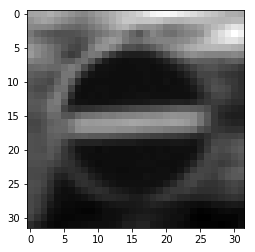

In [55]:
temp=gray(X_train[234])
plt.imshow(temp,cmap='gray')

In [8]:
#shuffle the training set

from sklearn.utils import shuffle

X_train_gray, y_train = shuffle(X_train_gray, y_train)

### Model Architecture

In [5]:

from tensorflow.contrib.layers import flatten
import tensorflow as tf
def mynet(x):
    kernel_size=(5,5)
    #32*32*1 conv2d to 28*28*6
    conv1=tf.layers.conv2d(x,6,kernel_size,strides=(1,1),padding='valid',activation=tf.nn.relu,
                           kernel_initializer=tf.contrib.layers.xavier_initializer())
    #28*28*6 to 14*14*6
    pool1=tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #14*14*6 conv2d to 10*10*16
    conv2=tf.layers.conv2d(pool1,16,kernel_size,strides=(1,1),padding='valid',activation=tf.nn.relu,
                           kernel_initializer=tf.contrib.layers.xavier_initializer())
    #10*10*16 maxpool to 5*5*16
    pool2=tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #flatten 5*5*16 to 400
    fc0=flatten(pool2)
    #fullconnect 400 to 120
    fc1=tf.layers.dense(fc0,120,activation=tf.nn.relu,
                        kernel_initializer=tf.contrib.layers.xavier_initializer())
    #fullconnect 120 to 43(logits)
    logits=tf.layers.dense(fc0,43,activation=None,
                        kernel_initializer=tf.contrib.layers.xavier_initializer())
    return logits

### Train, Validate and Test the Model

In [6]:
### Train model 
#1 input
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
#Training Pipeline
rate = 0.001
logits = mynet(x)
output=tf.nn.softmax(logits)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
train_opt = tf.train.AdamOptimizer(learning_rate = rate).minimize(loss_operation)
#Model evaluation use Valid dataset
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



In [9]:
### Train  model.and save the trained model
EPOCHS=30
BATCH_SIZE=128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_gray)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_gray, y_train = shuffle(X_train_gray, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_gray[offset:end], y_train[offset:end]
            sess.run((loss_operation,train_opt), feed_dict={x: batch_x, y: batch_y})
            #print("train cost = {:.3f}".format(loss_operation))
        train_accuracy=evaluate(X_train_gray, y_train)
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        validation_accuracy = evaluate(X_valid_gray, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, './mynet')
    print("Model saved")

Training...

Train Accuracy = 0.777
EPOCH 1 ...
Validation Accuracy = 0.776
Train Accuracy = 0.890
EPOCH 2 ...
Validation Accuracy = 0.882
Train Accuracy = 0.930
EPOCH 3 ...
Validation Accuracy = 0.920
Train Accuracy = 0.951
EPOCH 4 ...
Validation Accuracy = 0.940
Train Accuracy = 0.964
EPOCH 5 ...
Validation Accuracy = 0.950
Train Accuracy = 0.976
EPOCH 6 ...
Validation Accuracy = 0.959
Train Accuracy = 0.979
EPOCH 7 ...
Validation Accuracy = 0.964
Train Accuracy = 0.982
EPOCH 8 ...
Validation Accuracy = 0.966
Train Accuracy = 0.985
EPOCH 9 ...
Validation Accuracy = 0.969
Train Accuracy = 0.982
EPOCH 10 ...
Validation Accuracy = 0.961
Train Accuracy = 0.989
EPOCH 11 ...
Validation Accuracy = 0.970
Train Accuracy = 0.990
EPOCH 12 ...
Validation Accuracy = 0.972
Train Accuracy = 0.992
EPOCH 13 ...
Validation Accuracy = 0.975
Train Accuracy = 0.994
EPOCH 14 ...
Validation Accuracy = 0.978
Train Accuracy = 0.994
EPOCH 15 ...
Validation Accuracy = 0.975
Train Accuracy = 0.993
EPOCH 16 ...


In [10]:
BATCH_SIZE=128
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_gray, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\mynet
Test Accuracy = 0.917


---

## Step 3: Test a Model on New Images



### Load and Output the Images

In [11]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [12]:
#read all real german signs image
images=[]
for index in range(1,6):
    index=str(index)
    prefix='./real_german_traffic_signs/'
    img=mpimg.imread(prefix+index+'.jpg')
    images.append(img)

In [13]:
len(images)

5

In [14]:

#printing out some stats and plotting
#reading in an image
def blurZoomImg(image):
    #params:image is a single origin image 
    img=np.copy(image)
    img=cv2.GaussianBlur(img,(9,9),0)
    print('This Blur_image is:', type(img), 'with dimensions:', img.shape)
    #zoom in to shape 32*32*3
    img_zo=cv2.resize(img,(32,32),interpolation=cv2.INTER_AREA)
    print('This Zoom_image is:', type(img_zo), 'with dimensions:', img_zo.shape)
    #plt.imshow(img_zo)
    return img_zo
def gray1(img):
    #transform single image to gray pics
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
def scale1(input):
    #input:the gray tensor,scale the input to (-1,1) 
    return (input*1.0-128)/128
#preprocess image to the type need to feed into X placeholder.
def preprocess_gray1(input):
    #input:single origin pic for input
    X_new=blurZoomImg(input)
    X_new=gray1(X_new)
    X_new=np.array(X_new)
    print(type(X_new))
    #print('Before scale:',X_new.shape,'the mini value:',X_new.min(),'the maxi value is:',X_new.max())
    X_new=X_new.reshape([32,32,1])
    X_new=scale1(X_new)
    #print('After scale:',X_new.shape,'the mini value:',X_new.min(),'the maxi value is:',X_new.max())
    return X_new

real_x=[]
for each_img in images:
    real_x.append(preprocess_gray1(each_img))
real_x=np.array(real_x)
print('The real_x array shape is:{}'.format(real_x.shape))
## Feel free to use as many code cells as needed.

This Blur_image is: <class 'numpy.ndarray'> with dimensions: (1024, 768, 3)
This Zoom_image is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
<class 'numpy.ndarray'>
This Blur_image is: <class 'numpy.ndarray'> with dimensions: (478, 359, 3)
This Zoom_image is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
<class 'numpy.ndarray'>
This Blur_image is: <class 'numpy.ndarray'> with dimensions: (220, 229, 3)
This Zoom_image is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
<class 'numpy.ndarray'>
This Blur_image is: <class 'numpy.ndarray'> with dimensions: (194, 259, 3)
This Zoom_image is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
<class 'numpy.ndarray'>
This Blur_image is: <class 'numpy.ndarray'> with dimensions: (160, 240, 3)
This Zoom_image is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
<class 'numpy.ndarray'>
The real_x array shape is:(5, 32, 32, 1)


### Predict the Sign Type for Each Image

In [15]:

import pandas as pd
#read the signsname.csv
df=pd.read_csv(r'C:\Users\Administrator\Self driving\Term2\CarND-Traffic-Sign-Classifier-Project\signnames.csv')
name_list=np.array(df['SignName'])
#predict the real image
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    result = sess.run(output,feed_dict={x:real_x})
print(np.array(result).shape)

INFO:tensorflow:Restoring parameters from .\mynet
(5, 43)


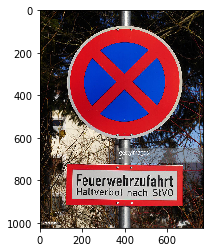

the NO.0 real sign image:class is:12,prediction is:Priority road


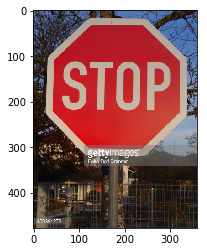

the NO.1 real sign image:class is:12,prediction is:Priority road


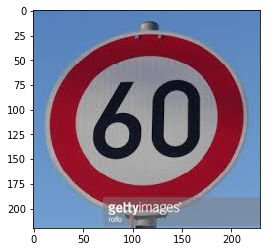

the NO.2 real sign image:class is:3,prediction is:Speed limit (60km/h)


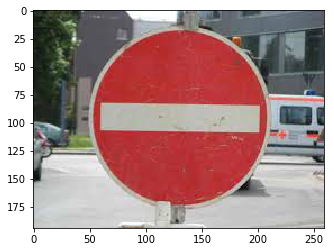

the NO.3 real sign image:class is:17,prediction is:No entry


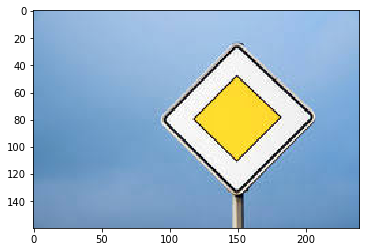

the NO.4 real sign image:class is:12,prediction is:Priority road


In [16]:
result=np.array(result)
prediction_y=[]
for row in range(len(images)):
    index=str(row+1)
    prefix='./real_german_traffic_signs/'
    img=mpimg.imread(prefix+index+'.jpg')
    plt.imshow(img)
    plt.show()
    prediction_y.append(np.argmax(result[row]))
    print('the NO.{} real sign image:class is:{},prediction is:{}'.format(row,np.argmax(result[row]),name_list[np.argmax(result[row])]))

### Analyze Performance

In [17]:

real_y=np.array([25,14,3,17,13])
prediction_y=np.array(prediction_y)
cnt=0
for index in range(len(real_y)):
    if real_y[index]==prediction_y[index]:
        cnt+=1
accurate=cnt*1.0/len(real_y)
print('The accurate on these new total six images is:{}'.format(accurate))

The accurate on these new total six images is:0.4


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [21]:
### Print out the top five softmax probabilities for the predictions 
with tf.Session() as sess:
    for row in range(len(images)):
        probabilities,indices=sess.run(tf.nn.top_k(result[row], k=5))
        #print('the NO. {} real traffic sign images top five probabilities is:{}'.format(row,probabilities))
        print('the NO. {} real traffic sign images top five probabilities is:'.format(row))
        for pro,index in zip(probabilities,indices):
            print('probabilities is:{:.5f},the class name is:{}'.format(pro,name_list[index]))

the NO. 0 real traffic sign images top five probabilities is:
probabilities is:0.59497,the class name is:Priority road
probabilities is:0.40502,the class name is:Roundabout mandatory
probabilities is:0.00001,the class name is:Speed limit (50km/h)
probabilities is:0.00000,the class name is:General caution
probabilities is:0.00000,the class name is:No entry
the NO. 1 real traffic sign images top five probabilities is:
probabilities is:0.99901,the class name is:Priority road
probabilities is:0.00092,the class name is:Speed limit (60km/h)
probabilities is:0.00006,the class name is:Right-of-way at the next intersection
probabilities is:0.00001,the class name is:No passing
probabilities is:0.00000,the class name is:Beware of ice/snow
the NO. 2 real traffic sign images top five probabilities is:
probabilities is:1.00000,the class name is:Speed limit (60km/h)
probabilities is:0.00000,the class name is:Speed limit (50km/h)
probabilities is:0.00000,the class name is:Speed limit (80km/h)
probabil

In [ ]:


def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")